<h1>Data Mining: Random Forest Regressor</h1>

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

def prepare_data(df):
    # Convert Excel date number to datetime
    df['Date'] = pd.to_datetime('1905-07-01') + pd.to_timedelta(df['DateSK'], unit='D')
    df['AQI'] = df['AQI'].astype(float)
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    
    for i in range(1, 8):
        df[f'AQI_lag_{i}'] = df['AQI'].shift(i)
    
    df['AQI_rolling_mean_7'] = df['AQI'].rolling(window=7).mean()
    df['AQI_rolling_mean_30'] = df['AQI'].rolling(window=30).mean()
    
    df = df.dropna()
    
    return df

def train_model(df):
    features = ['Month', 'Day', 'DayOfWeek', 'Quarter'] + \
              [f'AQI_lag_{i}' for i in range(1, 8)] + \
              ['AQI_rolling_mean_7', 'AQI_rolling_mean_30']
    
    X = df[features]
    y = df['AQI']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    return model, features, X_test, y_test

def generate_future_dates(start_date, periods):
    dates = pd.date_range(start=start_date, periods=periods, freq='D')
    future_df = pd.DataFrame({'Date': dates})
    future_df['Month'] = future_df['Date'].dt.month
    future_df['Day'] = future_df['Date'].dt.day
    future_df['DayOfWeek'] = future_df['Date'].dt.dayofweek
    future_df['Quarter'] = future_df['Date'].dt.quarter
    
    return future_df

def predict_future(model, df, features, start_date, periods):
    future_df = generate_future_dates(start_date, periods)
    predictions = []
    current_data = df.copy()
    
    for i in range(periods):
        pred_row = future_df.iloc[i:i+1].copy()
        
        for j in range(1, 8):
            pred_row[f'AQI_lag_{j}'] = current_data['AQI'].iloc[-(j):]
            
        pred_row['AQI_rolling_mean_7'] = current_data['AQI'].iloc[-7:].mean()
        pred_row['AQI_rolling_mean_30'] = current_data['AQI'].iloc[-30:].mean()
        
        prediction = model.predict(pred_row[features])[0]
        predictions.append(prediction)
        
        new_row = pred_row.copy()
        new_row['AQI'] = prediction
        current_data = pd.concat([current_data, new_row])
    
    future_df['Predicted_AQI'] = predictions
    return future_df

def plot_results(df, model, features, X_test, y_test, next_month, next_quarter):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(df['Date'], df['AQI'])
    plt.title('Historical AQI Time Series')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 2)
    predictions = model.predict(X_test)
    plt.scatter(y_test, predictions)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title('Prediction vs Actual')
    
    plt.subplot(2, 2, 3)
    importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    sns.barplot(data=importance, x='importance', y='feature')
    plt.title('Feature Importance')
    
    plt.subplot(2, 2, 4)
    plt.plot(next_month['Date'], next_month['Predicted_AQI'], label='Predicted')
    plt.title('Next Month AQI Predictions')
    plt.xticks(rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    

<h2> Prepare data and train model </h2>

In [5]:
df = pd.read_excel('DataFrame.xlsx')
prepared_df = prepare_data(df)
model, features, X_test, y_test = train_model(prepared_df)

<h2> Make prediction </h2>

In [7]:
last_date = prepared_df['Date'].max()
next_month = predict_future(model, prepared_df, features, last_date + pd.Timedelta(days=1), 31)
next_quarter = predict_future(model, prepared_df, features, last_date + pd.Timedelta(days=1), 90)

<h2> Plot results </h2>

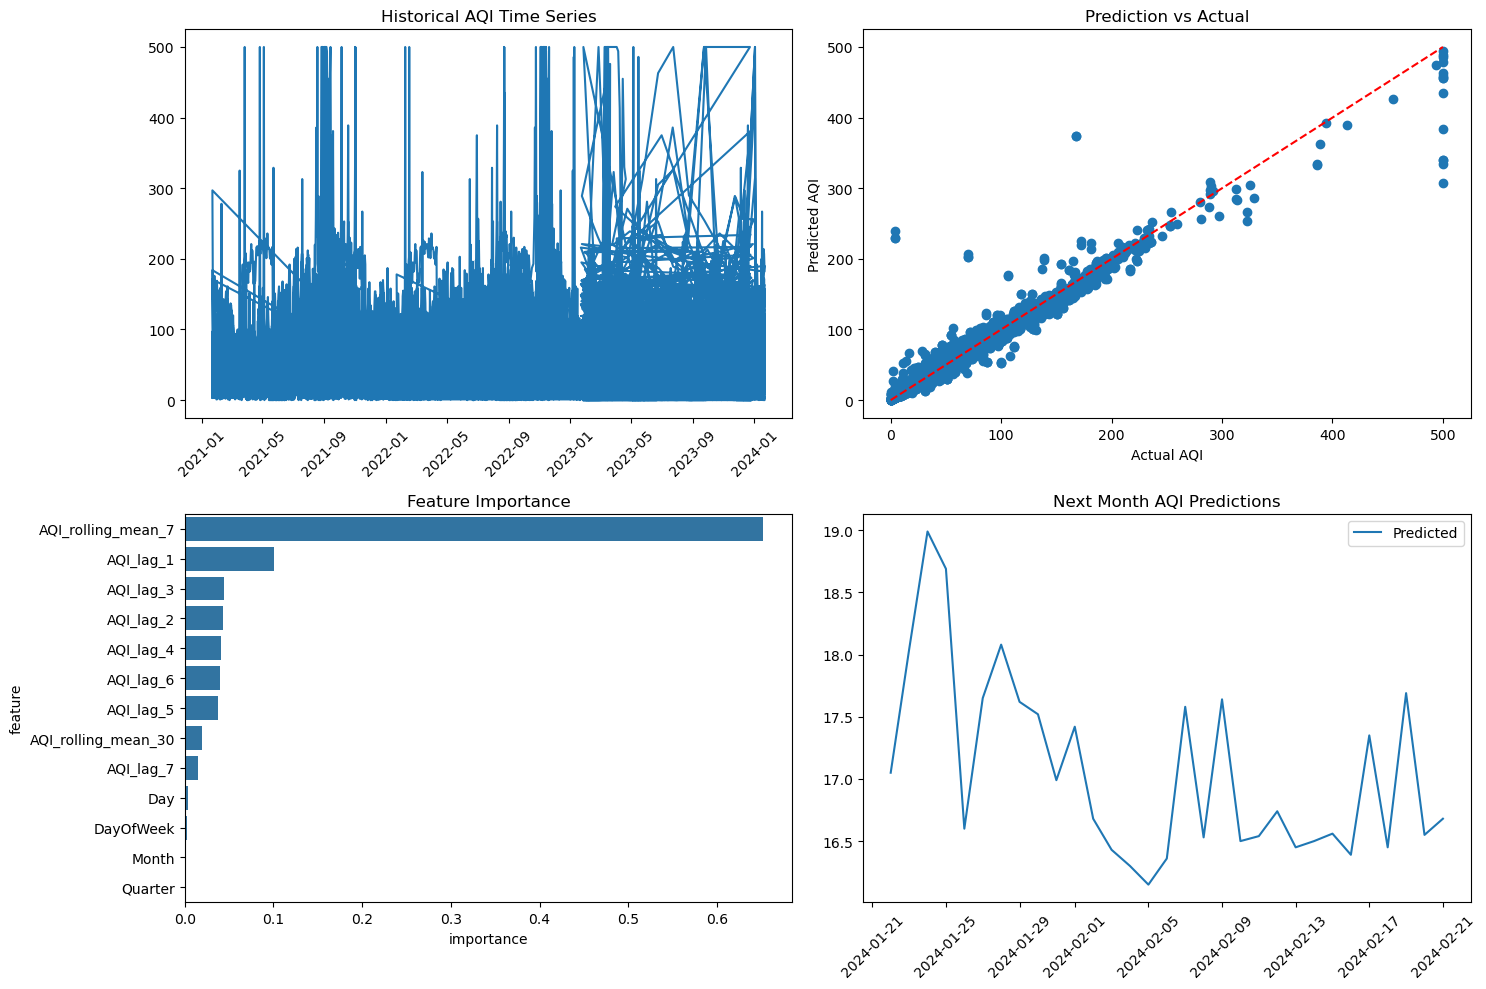

In [9]:
plot_results(prepared_df, model, features, X_test, y_test, next_month, next_quarter)

## 📊 **Nhận xét Dự Báo AQI Từ Mô Hình**

### **1. Xu hướng dự đoán:**
- **Giá trị AQI dự đoán:** Có xu hướng dao động trong khoảng từ **16.5 đến 19.0**, thể hiện sự biến động không quá lớn trong tháng tiếp theo.  
- **Đường dự đoán:** Đường dự đoán AQI thể hiện sự dao động nhẹ, giảm dần vào giữa tháng và tăng trở lại vào cuối tháng.

---

### **2. So sánh với dữ liệu lịch sử:**
- **Độ lệch giữa dự báo và thực tế:** Biểu đồ **"Prediction vs Actual"** cho thấy mô hình hoạt động tốt ở vùng giá trị thấp và trung bình, nhưng sai số đáng kể ở các giá trị AQI cao (**>300**).  
- **Tính chu kỳ/mùa vụ:** Mô hình chưa phản ánh rõ ràng các **chu kỳ hoặc tính mùa vụ** từ dữ liệu lịch sử.

---
